In [7]:
import imageio 
import matplotlib.pyplot as plt

In [148]:
import matplotlib as mpl


#axes.xaxis.set_tick_params(direction='in', which='both')
#axes.yaxis.set_tick_params(direction='in', which='both')
mpl.rcParams["xtick.direction"] = "in"
mpl.rcParams["ytick.direction"] = "in"
mpl.rcParams["lines.markeredgecolor"] = "k"
mpl.rcParams["lines.markeredgewidth"] = 0.1
mpl.rcParams["figure.dpi"] = 130
from matplotlib import rc
rc('font', family='serif')
rc('text', usetex=True)
rc('xtick', labelsize='x-small')
rc('ytick', labelsize='x-small')
def cm2inch(value):
    return value/2.54

In [8]:
vid = imageio.get_reader("Basler_acA1920-155um__22392621__20210407_173504486.mp4")

In [39]:
background = imageio.imread("background.tiff").astype(np.uint8)

In [40]:
def crop(im, x, y, size = 200):
    return im[(x-size//2):(x+size//2),(y-size//2):(y+size//2)]

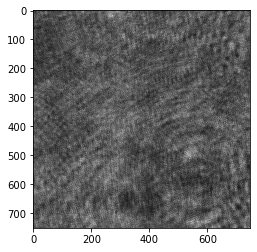

In [41]:
plt.imshow(background, cmap="gray")

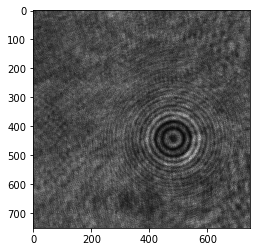

In [42]:
plt.imshow(vid.get_data(10000)[:,:,1], cmap="gray")

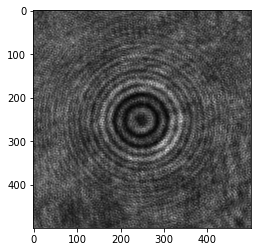

In [43]:
plt.imshow(crop(vid.get_data(10000)[:,:,1],440,485, 500), cmap="gray")

In [44]:
im =crop(vid.get_data(10000)[:,:,1],440,485, 500)

In [45]:
bg = crop(background,440,485, 500)

In [46]:
normalized = im / bg

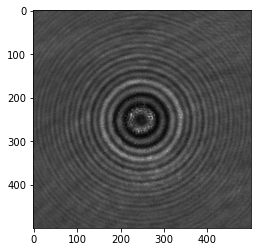

In [47]:
plt.imshow(normalized, cmap="gray")

In [48]:
imageio.imsave("exp.tiff", im)
imageio.imsave("norm.tiff", normalized)

In [50]:
imageio.imsave("bg.tiff", bg)

In [37]:
bg

Array([[25., 27., 30., ..., 24., 23., 20.],
       [32., 32., 32., ..., 31., 30., 26.],
       [30., 33., 36., ..., 31., 31., 30.],
       ...,
       [43., 40., 36., ..., 43., 33., 29.],
       [38., 39., 39., ..., 40., 31., 25.],
       [34., 36., 38., ..., 29., 25., 22.]])

In [29]:
imageio.imread("bg.tiff")

Array([[25., 27., 30., ..., 24., 23., 20.],
       [32., 32., 32., ..., 31., 30., 26.],
       [30., 33., 36., ..., 31., 31., 30.],
       ...,
       [43., 40., 36., ..., 43., 33., 29.],
       [38., 39., 39., ..., 40., 31., 25.],
       [34., 36., 38., ..., 29., 25., 22.]])

In [84]:
import holopy as hp
import numpy as np
from holopy.core.io import get_example_data_path, load_average
from holopy.core.process import bg_correct, subimage, normalize, center_find
from holopy.scattering import Sphere, Spheres, calc_holo, Mie
from holopy.inference import prior, ExactModel, CmaStrategy, EmceeStrategy, AlphaModel, NmpfitStrategy

In [67]:
raw_holo = hp.load_image("exp.tiff", spacing = 0.0535, medium_index = 1.33, illum_wavelen=0.532, illum_polarization = (1,0))


In [68]:
bg = hp.load_image("bg.tiff", spacing = 0.0535, medium_index = 1.33, illum_wavelen=0.532, illum_polarization = (1,0))

In [69]:
data_holo = bg_correct(raw_holo, bg)

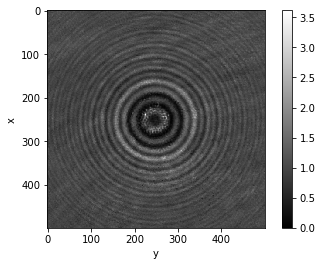

In [70]:
hp.show(data_holo)

In [71]:
center_find(data_holo)

array([252.93957285, 248.33754432])

In [72]:
data_holo = subimage(data_holo, center_find(data_holo), 450)

In [73]:
data_holo = normalize(data_holo)

In [78]:
guess_sphere = Sphere(n = 1.59, r = 2.5, center = [250*0.0535, 250*0.0535, 16])

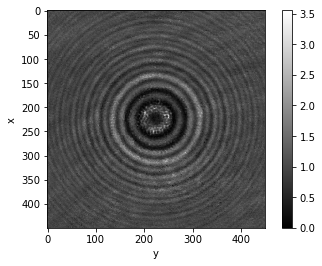

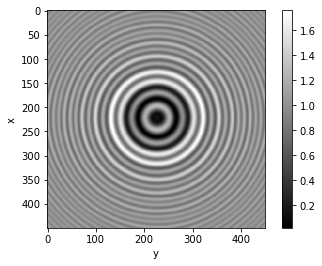

In [79]:
initial_guess = calc_holo(data_holo, guess_sphere)
hp.show(data_holo)
hp.show(initial_guess)

In [175]:
parameters_to_fit = ['x', 'y', 'z', "n"]
fit_result = hp.fit(data_holo, guess_sphere, parameters=parameters_to_fit)

In [176]:
fit_result

FitResult(data=<xarray.DataArray 'exp' (z: 1, x: 450, y: 450)>
array([[[1.09602974, 1.06809495, 1.09825292, ..., 0.94170371,
         0.86472967, 0.90076007],
        [0.92805583, 0.95193962, 0.98264735, ..., 0.89052416,
         0.85162771, 0.94170371],
        [0.85666692, 0.90076007, 0.88438262, ..., 0.91925075,
         0.90985866, 0.98264735],
        ...,
        [0.89052416, 0.87346431, 0.9089488 , ..., 0.98264735,
         0.90076007, 0.90985866],
        [0.95193962, 0.92123189, 0.92484457, ..., 0.95287016,
         0.92123189, 0.86926497],
        [0.98264735, 1.01653175, 0.95287016, ..., 1.05543605,
         0.90985866, 0.78611788]]])
Coordinates:
  * z        (z) int32 0
  * x        (x) float64 1.498 1.551 1.605 1.658 ... 25.36 25.41 25.47 25.52
  * y        (y) float64 1.23 1.284 1.337 1.391 1.444 ... 25.09 25.14 25.2 25.25
Attributes:
    medium_index:        1.33
    illum_wavelen:       0.532
    illum_polarization:  <xarray.DataArray (vector: 3)>\narray([1., 0., 0.])\

In [177]:
fit_result.parameters

{'n': 1.5905037038947403,
 'x': 13.505990601672131,
 'y': 13.279141180431893,
 'z': 14.771143014704023,
 'alpha': 0.9196105249145826}

In [178]:
result = calc_holo(data_holo, fit_result.scatterer)


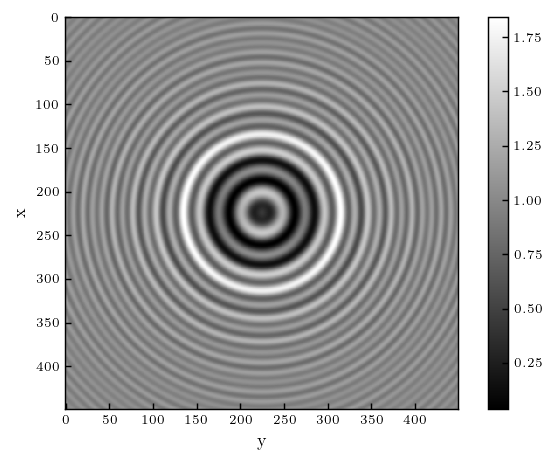

In [179]:
hp.show(result)

In [180]:
result.data

array([[[0.97398933],
        [0.96659938],
        [0.96911   ],
        ...,
        [0.98774203],
        [0.97300209],
        [0.96642063]],

       [[0.96649216],
        [0.96898621],
        [0.98079871],
        ...,
        [1.00689542],
        [0.98777865],
        [0.97290681]],

       [[0.96879643],
        [0.98063313],
        [0.99869713],
        ...,
        [1.02524645],
        [1.0069194 ],
        [0.98765631]],

       ...,

       [[0.9681009 ],
        [0.97907583],
        [0.99669524],
        ...,
        [1.02354721],
        [1.00489021],
        [0.98585292]],

       [[0.9668262 ],
        [0.96827989],
        [0.97923578],
        ...,
        [1.00486421],
        [0.98597138],
        [0.97180626]],

       [[0.97526137],
        [0.96692819],
        [0.96840175],
        ...,
        [0.98593534],
        [0.97190091],
        [0.96631276]]])

In [181]:
def radial_profile(data, center=None):
    if center==None:
        center = np.array(np.shape(data)) / 2
    
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    
    T = data.ravel()
    V = r.ravel()
    
    err = [np.std(T[V == u]) for u in np.unique(V)]
    
    return radialprofile, err

In [182]:
rad, err = radial_profile(result.data[:,:,0])
rade, erre = radial_profile(data_holo.data[0,:,:])

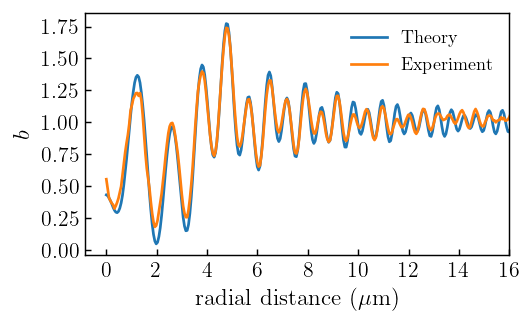

In [254]:
x = np.arange(len(rad)) * 0.0535

plt.figure(figsize= (cm2inch(16/3*2), cm2inch(16/3*2)/1.618))
plt.plot(x,rad, label = "Theory")
plt.plot(x,rade, label = "Experiment")
plt.legend(frameon=False)
plt.xlabel("radial distance ($\mathrm{\mu m}$)", fontsize = 13)
plt.xlim((None, 16))
plt.ylabel("$b$", fontsize = 13)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.tight_layout()
plt.savefig("radial intensity.svg")

In [229]:
from matplotlib_scalebar.scalebar import ScaleBar

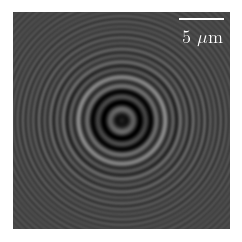

In [248]:
plt.figure(figsize = (cm2inch(5), cm2inch(5)))
A = result.data[:,:]
plt.imshow(A, cmap="gray", vmin=np.min(A), vmax=np.max(A)*1.9)
plt.axis("off")
ax = plt.gca()
scalebar = ScaleBar(0.0535, "um", length_fraction=0.25, frameon=False, color="white")
ax.add_artist(scalebar)
plt.tight_layout()
plt.savefig("experimental.svg")
plt.savefig("fit.svg")

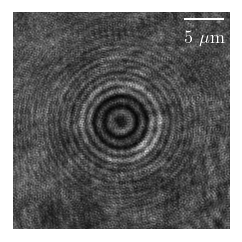

In [237]:
plt.figure(figsize = (cm2inch(5), cm2inch(5)))
plt.imshow(im, cmap="gray")
plt.axis("off")
ax = plt.gca()
scalebar = ScaleBar(0.0535, "um", length_fraction=0.25, frameon=False, color="white")
ax.add_artist(scalebar)
plt.tight_layout()
plt.savefig("experimental.svg")

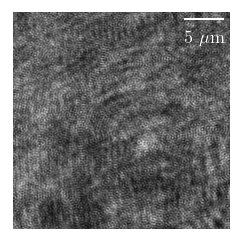

In [238]:
plt.figure(figsize = (cm2inch(5), cm2inch(5)))
plt.imshow(bg[0,:,:], cmap="gray")
plt.axis("off")
ax = plt.gca()
scalebar = ScaleBar(0.0535, "um", length_fraction=0.25, frameon=False, color="white")
ax.add_artist(scalebar)
plt.tight_layout()
plt.savefig("bg.svg")

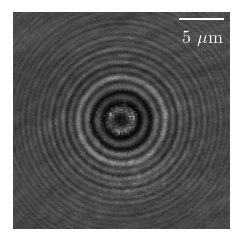

In [239]:
plt.figure(figsize = (cm2inch(5), cm2inch(5)))
plt.imshow(data_holo.data[0,:,:], cmap="gray")
plt.axis("off")
ax = plt.gca()
scalebar = ScaleBar(0.0535, "um", length_fraction=0.25, frameon=False, color="white")
ax.add_artist(scalebar)
plt.tight_layout()
plt.savefig("normalized.svg")